In [20]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sp
from scipy import fft
from numpy import linalg as LA


Variable initialization

In [2]:
M = 32 # signal dimension
N = 2 * M # number of atoms in the expansion


C = np.zeros((M, M)) # matrix containing the standard basis (a kronecker delta in each column)
DCT = np.zeros((M, M)) #matrix containing the DCT basis (a DCT function in each column)

Generate the 1D-DCT basis

In [3]:
for i in range(M):
  a = np.zeros(M)
  a[i] = 1
  DCT[:, i] = sp.fftpack.idct(a, norm='ortho')

Generating the 1-D standard basis

In [5]:
for i in range(M):
    C[i, i] = 1


Define the dictionary $D = [DCT, C]$

Text(0.5, 1.0, 'Our dictionary M = 32, N = 64')

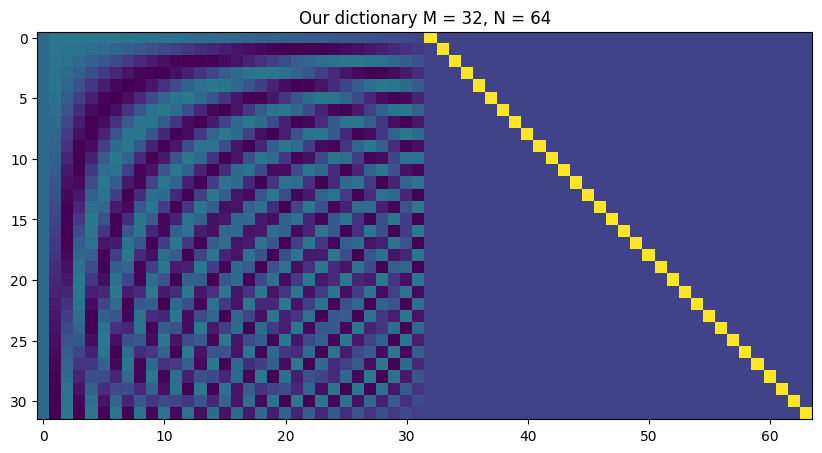

In [6]:
D = np.hstack((DCT, C))

plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title(f'Our dictionary M = {M}, N = {N}')

Generate a signal that is sparse w.r.t. $[DCT, C]$
-----------------------------------------
To this purpose add a spike to the sum of few DCT atoms, i.e., add a spike to $\mathbf{s}$ that is sparse w.r.t. C. Bear in mind that the spike is to be considered a signal to be reconstructed, rather than noise

In [7]:
L = 5
sigma_noise = 0.2

Randomly define the coefficients of a sparse representation w.r.t. $DCT$ (make sure the nonzero coefficients are sufficiently large)

In [9]:
def generate_sparse_representation(L, M):
    indexes = np.random.choice(M, L, replace=False)
    #coefficients = np.random.uniform(200, 1000, size=L)
    coefficients = 5 * np.random.rand(L)
    x0 = np.zeros(M)
    x0[indexes] = coefficients
    return x0

In [14]:
x0 = generate_sparse_representation(L, N)

Text(0.5, 1.0, 'Original signal')

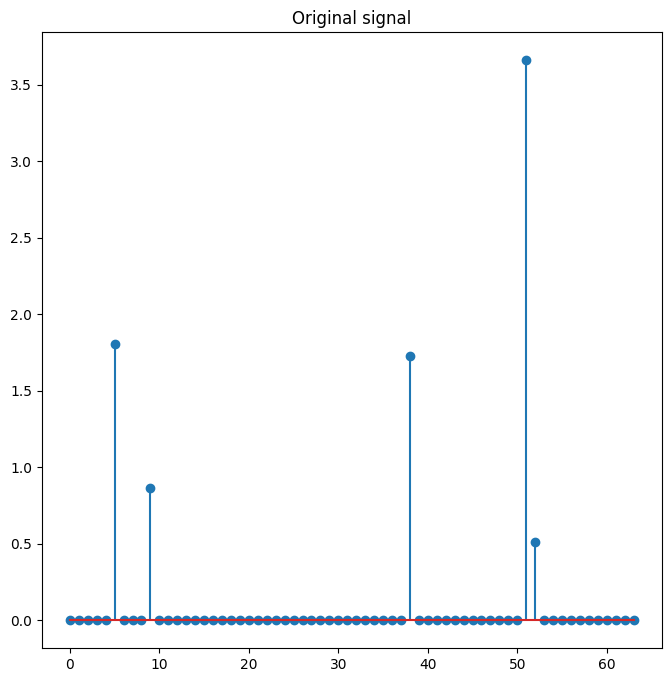

In [15]:
# plot x0
plt.figure(figsize=(8,8))
plt.stem(x0)
plt.title('Original signal')



Choose spike location and update $x_0$

In [16]:
# Choose random position from M to N (N=2M)
spikeLocation = np.random.choice(range(M, N))
lambda_spike = 5 * np.abs(max(x0))
x0[spikeLocation] = lambda_spike

Synthetize the corresponding signal in the signal domain and add noise


In [17]:
s0 = np.dot(D, x0)
s = s0 + sigma_noise * np.random.normal(size=s0.shape)

Plot the sparse signal

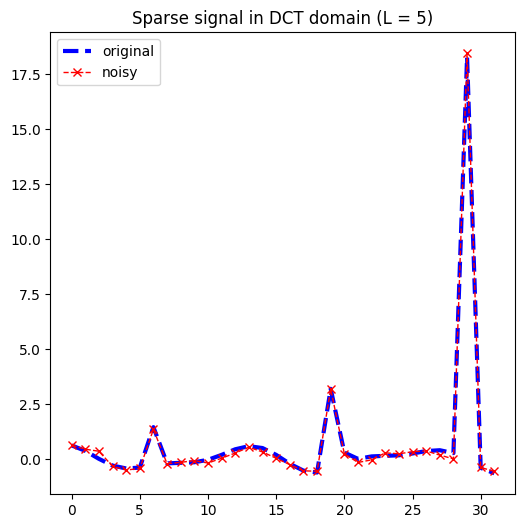

In [18]:
LN_WDT = 2
MRK_SZ = 10

plt.figure(figsize=(6, 6))
plt.plot(s0, 'b--', linewidth=LN_WDT+1)
plt.plot(s, 'r--x', linewidth=LN_WDT-1)
plt.title(f'Sparse signal in DCT domain (L = {L:.0f})')
plt.legend(['original', 'noisy'])


Matching Pursuit
----------------

Initialize all the variables, including the residual, namely the components of the signals that can not be represented (here the signal at the very beginning)

In [21]:
x_MP = np.zeros(N)

r = s

l = 1

#initialize the norm of the resiudal (components not represented by the coefficients)

resNorm = LA.norm(r, 2)

MINIMUM_RES_NORM = 0.1


MP loop starts.

Stoppint criteria: continue until the sparsity of the representation reaches L or as long as resNorm(l) is above a minimum value or as long as a maxium number of iterations have been reached

In [22]:
while np.count_nonzero(x_MP) < L and resNorm > MINIMUM_RES_NORM and l < 2*L:

    # SWEEP STEP: look for the column of D that matches at best noisySignal
    # compute the residual w.r.t. each column of D
    e = np.zeros(N)
    for j in range(N):
        dj = D[:, j]
        e[j] = resNorm**2 - (np.dot(r.T, dj))**2
        # this corresponds to solving e(j) = min( || dj zj - s ||),
        # which is obtained by setting zj = dj' r / || dj ||^2 (analytically defined)
        # there is no need to divide by || dj ||^2 since columns are nomalized

    # find the column of D that matches at best r, i.e. jStar = argmin(e(j))
    jStar = np.argmin(e)

    # UPDATE the jStar coefficient by *summing* the new component dj' r^(i) / || dj ||^2
    djStar = D[:, jStar]

    # UPDATE the residual
    x_MP[jStar] = x_MP[jStar] + np.dot(djStar, r) / LA.norm(djStar, 2)**2

    # remove the signal we have so far represented in coeff_MP (update the residual)
    r = s - np.dot(D, x_MP  )  # component that cannot be captured by the signal (the signal at the very beginning)

    l = l + 1

    # update the residual norm
    resNorm = LA.norm(r)

In [23]:
print(x_MP)

[ 0.          0.          0.          0.          0.          1.45082144
  0.          0.          0.          0.72777351  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.36104575  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          3.18833872  0.          0.
  0.          0.          0.          0.          0.          0.
  0.         18.4413335   0.          0.        ]


SYNTHESIS: reconstruct the signal, by inverting the transformation to reconstruct the signal

In [24]:
s_hat_MP = np.dot(D, x_MP)

Those part of the signal that have not been modeled by s_hat (i.e. the projection on the subspace of the L most involved coefficients) corresponds to the norm of the residual

In [25]:
resNorm_MP = LA.norm(s_hat_MP)

Show the result

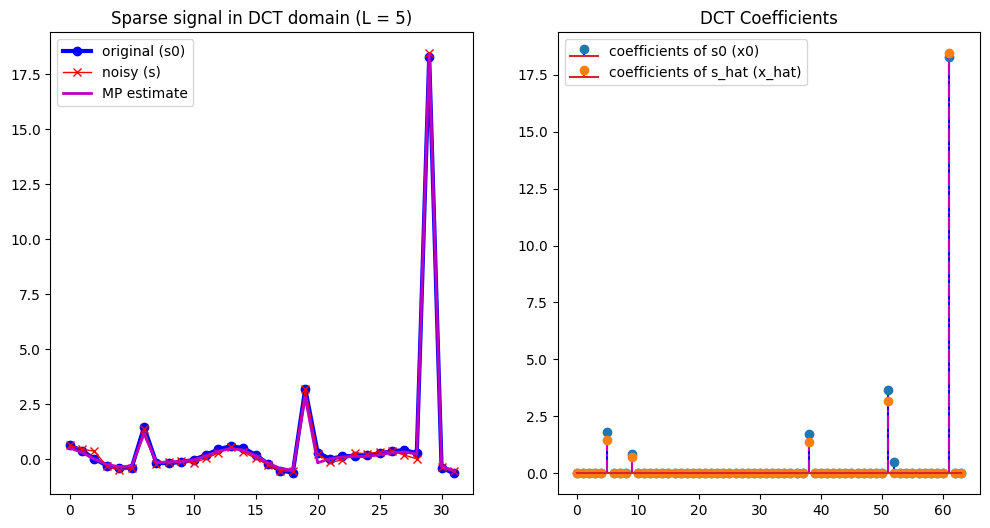

In [26]:
LN_WDT = 2
MRK_SZ = 10

fix, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(s0, 'b-o', linewidth=LN_WDT + 1)
ax[0].plot(s, 'r-x', linewidth=LN_WDT - 1)
ax[0].plot(s_hat_MP, 'm-', linewidth=LN_WDT)
ax[0].set_title(f'Sparse signal in DCT domain (L = {L:.0f})')
ax[0].legend(['original (s0)', 'noisy (s)', 'MP estimate'])

ax[1].stem(x0, linefmt='b-', markerfmt='C0o')
ax[1].stem(x_MP, linefmt='m-.', markerfmt='C1o')
ax[1].set_title('DCT Coefficients')
ax[1].legend(['coefficients of s0 (x0)', 'coefficients of s_hat (x_hat)'])

